In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gdrive_path = '/content/drive/MyDrive/mydata'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, MultiHeadAttention, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import string
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.metrics import edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle
import itertools
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
whole_data = pd.read_csv("Supervised_whole_data.csv")
train_data = pd.read_csv("supervised_train_data.csv")
test_data = pd.read_csv("supervised_test_data.csv")

In [ ]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

NORMAL = 0
ABNORMAL = 1
CLASSIFICATION_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "att_lstm_w2v_cbow.sav"
WORD2VEC_MODEL = "att_model.w2v_cbow"
TOKENIZER_MODEL = "att_w2v_tokenizer_cbow.pkl"
ENCODER_MODEL = "att_encoder_cbow.pkl"

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
# TEXT CLEANING
TEXT_CLEANING = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

def preprocess(text, stem=False):

    text = re.sub(TEXT_CLEANING, ' ', str(text).lower()).strip()
    tokens = []

    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)

    return " ".join(tokens)

In [ ]:
whole_data.conclusion = whole_data.conclusion.apply(lambda x: preprocess(x))
train_data.conclusion = train_data.conclusion.apply(lambda x: preprocess(x))
test_data.conclusion = test_data.conclusion.apply(lambda x: preprocess(x))

In [ ]:
whole_data.sample(10)

,conclusion,Abnormal
4223,eeg sleep wakefulness within normal limits,0.0
3133,eeg showed marked diffuse attenuation without ...,1.0
108,frequent theta slow wave temporal regions poly...,1.0
5056,eeg within normal limits,0.0
1033,intermittent slow waves seen independantly bit...,0.0
1655,eeg shows generalized attenuation low amplitud...,1.0
1030,eeg normal,0.0
4828,eeg customary,0.0
1372,eeg within normal limits,0.0
1230,abnormal eeg sharp waves l posterior quadrant ...,1.0


In [ ]:
X_train, y_train = train_data["conclusion"].values, train_data["Abnormal"].values
X_test, y_test = test_data["conclusion"].values, test_data["Abnormal"].values

In [ ]:
documents = [_text.split() for _text in whole_data.conclusion]
print(len(documents))

6448


In [ ]:
cbow_w2v = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=0)

In [ ]:
words = cbow_w2v.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 473


In [ ]:
cbow_w2v.wv.most_similar("abnormal")

[('mildly', 0.9684221148490906),
 ('bitemporal', 0.9683609008789062),
 ('intermittent', 0.9630005359649658),
 ('slow', 0.9614043235778809),
 ('occasionally', 0.9545653462409973),
 ('wave', 0.9494514465332031),
 ('posterior', 0.9486069679260254),
 ('isolated', 0.9456438422203064),
 ('frontotemporal', 0.9431381821632385),
 ('side', 0.9408008456230164)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(whole_data.conclusion)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2237


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [ ]:
encoder = LabelEncoder()
encoder.fit(whole_data.Abnormal.tolist())
y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (5948, 1)
y_test (500, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5948, 300)
y_train (5948, 1)

x_test (500, 300)
y_test (500, 1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
 if word in cbow_w2v.wv:
    embedding_matrix[i] = cbow_w2v.wv[word]
print(embedding_matrix.shape)

(2237, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
class Custom_Attention(Layer):

  def __init__(self, return_sequences=True):
    self.return_sequences = return_sequences
    super(Custom_Attention, self).__init__()

  def build(self, input_shape):

    self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
    self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")

    super(Custom_Attention, self).build(input_shape)

  def call(self, x):

    e = K.tanh(K.dot(x, self.W) + self.b)
    a = K.softmax(e, axis=1)
    output = x*a

    if self.return_sequences:
      return output

    return K.sum(output, axis=1)

In [91]:
cbow_att_model = Sequential()
cbow_att_model.add(embedding_layer)
cbow_att_model.add(Dropout(0.5))
cbow_att_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
cbow_att_model.add(Custom_Attention(return_sequences=False))
cbow_att_model.add(Dropout(0.5))
cbow_att_model.add(Dense(1, activation='sigmoid', kernel_regularizer='l1'))
cbow_att_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          671100    
                                                                 
 dropout_11 (Dropout)        (None, 300, 300)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 300, 200)          320800    
 onal)                                                           
                                                                 
 custom__attention_3 (Custo  (None, 200)               500       
 m_Attention)                                                    
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [92]:
cbow_att_model.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["accuracy"])

In [93]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=8)]

In [94]:
history = cbow_att_model.fit(x_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_split=0.1,
                         verbose=1,
                         callbacks=callbacks)

cbow_att_model.save(KERAS_MODEL)
cbow_att_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

Epoch 1/32
6/6 [==============================] - 17s 2s/step - loss: 0.8441 - accuracy: 0.5563 - val_loss: 0.7807 - val_accuracy: 0.5227 - lr: 0.0010
Epoch 2/32
6/6 [==============================] - 11s 2s/step - loss: 0.7330 - accuracy: 0.8083 - val_loss: 0.5916 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 3/32
6/6 [==============================] - 11s 2s/step - loss: 0.5247 - accuracy: 0.9335 - val_loss: 0.3914 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 4/32
6/6 [==============================] - 10s 2s/step - loss: 0.3755 - accuracy: 0.9533 - val_loss: 0.3459 - val_accuracy: 0.9378 - lr: 0.0010
Epoch 5/32
6/6 [==============================] - 10s 2s/step - loss: 0.3249 - accuracy: 0.9464 - val_loss: 0.3406 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 6/32
6/6 [==============================] - 11s 2s/step - loss: 0.3152 - accuracy: 0.9413 - val_loss: 0.3331 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 7/32
6/6 [==============================] - 11s 2s/step - loss: 0.3026 - accuracy: 0.948

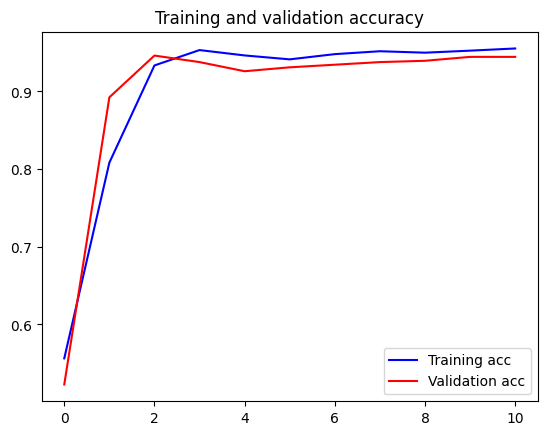

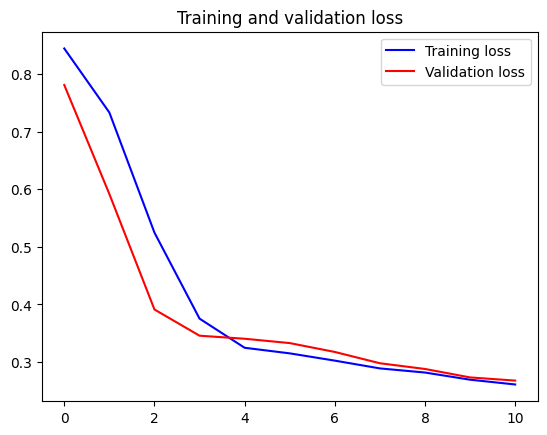

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [96]:
%%time
score = cbow_att_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 251ms/step - loss: 0.2389 - accuracy: 0.9600

ACCURACY: 0.9599999785423279
LOSS: 0.23894843459129333
CPU times: user 253 ms, sys: 42.9 ms, total: 296 ms
Wall time: 368 ms


In [97]:
def decode_prediction(score):
  return NORMAL if score < 0.5 else ABNORMAL

In [98]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = cbow_att_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_prediction(score) for score in scores]

1/1 [==============================] - 1s 717ms/step
CPU times: user 743 ms, sys: 51.8 ms, total: 795 ms
Wall time: 840 ms


In [99]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
  plt.yticks(tick_marks, classes, fontsize=22)

  fmt = '.2f'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

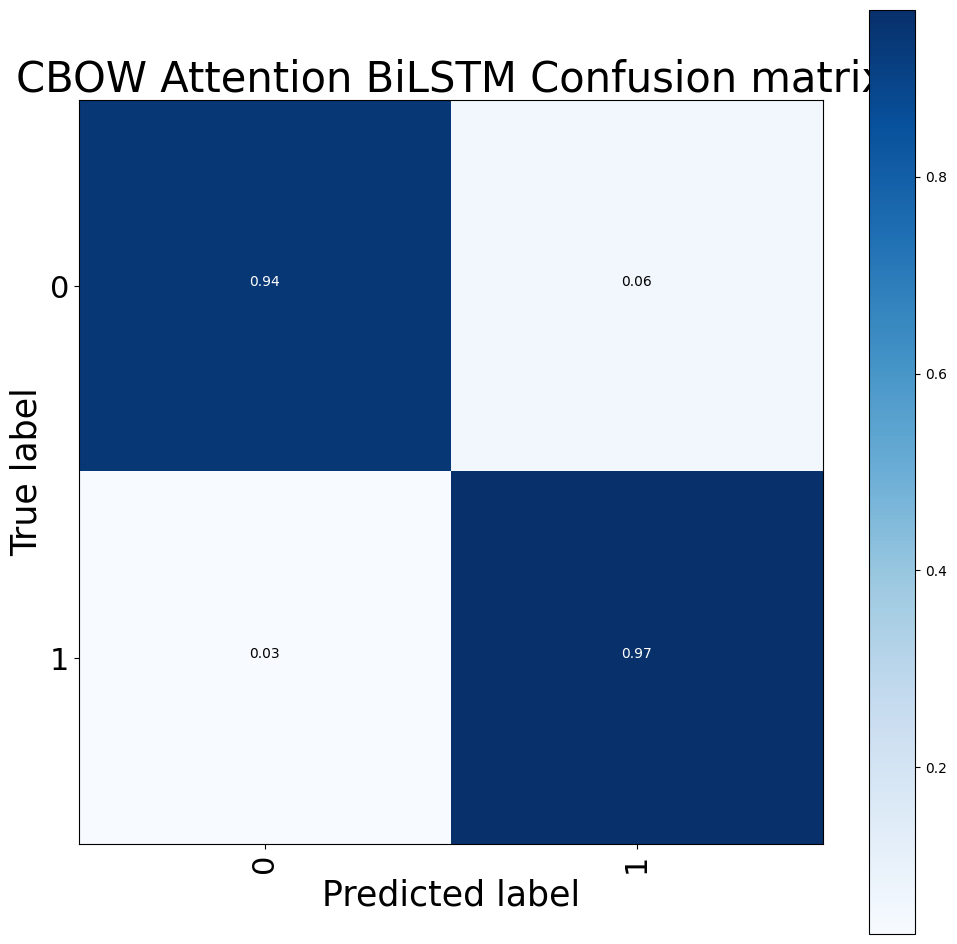

CPU times: user 342 ms, sys: 229 ms, total: 571 ms
Wall time: 339 ms


In [100]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="CBOW Attention BiLSTM Confusion matrix")
plt.show()

In [101]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       176
           1       0.97      0.97      0.97       324

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



In [102]:
accuracy_score(y_test_1d, y_pred_1d)

0.96

In [ ]:
cbow_att_model.save(f"{gdrive_path}{KERAS_MODEL}")
cbow_w2v.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)

In [ ]:
# download the trained model
import shutil
shutil.make_archive("/content/drive/MyDrive/mydata", 'zip', "/content/drive/MyDrive/mydata")
from google.colab import files
files.download("/content/drive/MyDrive/mydata.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>